In [12]:
import numpy as np
import pandas as pd

import seaborn as sns
from matplotlib import pyplot as plt

import re

import nltk
nltk.download('punkt')

from googletrans import Translator

import torch
from transformers import AutoTokenizer, AutoModel

# sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split

# keras
from keras.models import Sequential, load_model
from keras.layers import Embedding, Bidirectional, LSTM, Dense, Conv1D, GlobalMaxPooling1D, Dropout
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from keras_contrib.layers import CRF
from keras_contrib.losses import crf_loss
from keras_contrib.metrics import crf_viterbi_accuracy

import pickle

from imblearn.over_sampling import SMOTE

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\husse\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [13]:
df = pd.read_csv("datasets/new_merged_df.csv")
df

,text,emotion
0,da ana lma atkharrag,joy
1,baad el fetar hagelko,neutral
2,hahahahahha helw elkalam dah,happiness
3,kan 3ayz yroh yl3ab fe pyramids bayen,neutral
4,dah elly ana asdi aleih harfyan,neutral
...,...,...
2804,eh el araf da ana mt3sab,angry
2805,tab law omt w gbthalk..,neutral
2806,ana msh msda2 ana masdoom,surprise
2807,eh el mofg2at el 8areba de,surprise


neutral: Count = 867 -----------------> Percentage = 30.87%
joy: Count = 694 -----------------> Percentage = 24.71%
happiness: Count = 547 -----------------> Percentage = 19.47%
angry: Count = 394 -----------------> Percentage = 14.03%
sadness: Count = 155 -----------------> Percentage = 5.52%
surprise: Count = 91 -----------------> Percentage = 3.24%
fear: Count = 61 -----------------> Percentage = 2.17%


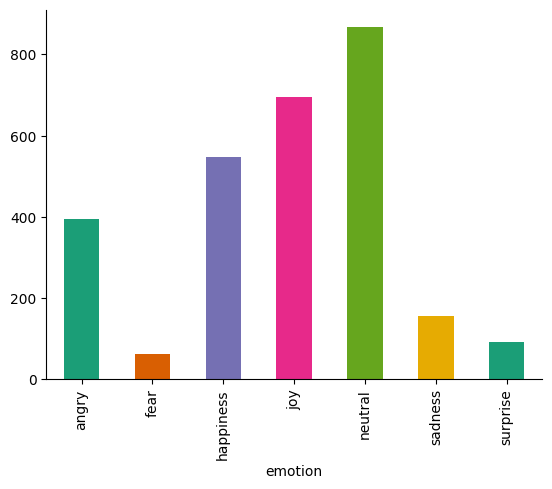

In [14]:
df.groupby('emotion').size().plot(kind='bar', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right']].set_visible(False)

# Calculating and printing percentages in descending order
emotion_counts = df['emotion'].value_counts()
total_samples = len(df)

for emotion, count in emotion_counts.items():
    percentage = (count / total_samples) * 100
    print(f"{emotion}: Count = {count} -----------------> Percentage = {percentage:.2f}%")

In [15]:
def clean_text(text):
    # Remove URLs https://www.example.com/
    text = re.sub(r'http\S+', '', text)
    # Remove user mentions @User_name
    text = re.sub(r'@[A-Za-z0-9_]+', '', text)
    # Remove hashtags #free_palestine
    text = re.sub(r'#', '', text)
    # Remove punctuation period, comma, apostrophe, quotation, question, exclamation, brackets, braces, parenthesis, dash, hyphen, ellipsis, colon, semicolon
    text = re.sub(r'[^\w\s]', '', text)
    # Tokenize the text
    tokens = nltk.word_tokenize(text)
    # Convert to lower case
    tokens = [word.lower() for word in tokens]
    # Join the tokens back into a clean text
    clean_text = ' '.join(tokens)
    return clean_text

df['clean_text'] = df['text'].apply(clean_text)

In [17]:
def translate_to_arabic(text):
    translator = Translator()
    translation = translator.translate(text, dest='ar')
    return translation.text

df['arabic_text'] = df['clean_text'].apply(translate_to_arabic)

In [18]:
AraBERT_tokenizer = AutoTokenizer.from_pretrained("asafaya/bert-base-arabic")
AraBERT_model = AutoModel.from_pretrained("asafaya/bert-base-arabic")

def get_embeddings(text):
    tokens = AraBERT_tokenizer(text, return_tensors="pt")
    with torch.no_grad():
        outputs = AraBERT_model(**tokens)
    return outputs.last_hidden_state.mean(dim=1).squeeze().detach().numpy()

df['arabert_embeddings'] = df['arabic_text'].apply(get_embeddings)

In [19]:
X = df['arabert_embeddings'].astype(str).tolist()
y = df['emotion']

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)
X_sequences = tokenizer.texts_to_sequences(X)

X_padded = pad_sequences(X_sequences)

#train test split
X_train, X_test, y_train, y_test = train_test_split(X_padded, y, test_size=0.2, random_state=42)

# Apply SMOTE to balance the training data only
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)


In [21]:
after_embedding_df = df.copy()
after_embedding_df.to_csv('merge_embedding.csv', index=False)

In [20]:
model_lstm = Sequential()
model_lstm.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=50, input_length=X_padded.shape[1]))
model_lstm.add(Bidirectional(LSTM(64,return_sequences=True)))
model_lstm.add(Bidirectional(LSTM(32)))
model_lstm.add(Dense(64, activation='relu'))
model_lstm.add(Dense(7, activation='softmax'))

model_lstm.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])   

model_lstm.fit(X_train_balanced, y_train_balanced, epochs=10, batch_size=32, validation_split=0.1)

y_pred_lstm = np.argmax(model_lstm.predict(X_test), axis=1)
accuracy_lstm = accuracy_score(y_test, y_pred_lstm)

print(f"LSTM Model Accuracy: {accuracy_lstm * 100:.2f}%")

y_pred_lstm = np.argmax(model_lstm.predict(X_test), axis=1)
accuracy_lstm = accuracy_score(y_test, y_pred_lstm)

print(f"LSTM Model Accuracy: {accuracy_lstm * 100:.2f}%")




Epoch 1/10


137/137 [==============================] - 676s 5s/step - loss: 1.9066 - accuracy: 0.1679 - val_loss: 3.0474 - val_accuracy: 0.0000e+00
Epoch 2/10
137/137 [==============================] - 419s 3s/step - loss: 1.5755 - accuracy: 0.3792 - val_loss: 4.1160 - val_accuracy: 0.0000e+00
Epoch 3/10
137/137 [==============================] - 2908s 21s/step - loss: 0.5412 - accuracy: 0.8169 - val_loss: 6.1763 - val_accuracy: 0.0021
Epoch 4/10
101/137 [=====================>........] - ETA: 11:53 - loss: 0.0982 - accuracy: 0.9743

KeyboardInterrupt: 

In [ ]:
model_cnn = Sequential()
model_cnn.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=50, input_length=X_padded.shape[1]))
model_cnn.add(Conv1D(128, 5, activation='relu'))
model_cnn.add(GlobalMaxPooling1D())
model_cnn.add(Dense(64, activation='relu'))
# model_cnn.add(Dropout(0.5))
model_cnn.add(Dense(7, activation='softmax'))

# Add CRF layer----------------------------------
# model_cnn.add(CRF(7))
# model_cnn.compile(optimizer='adam', loss=crf_loss, metrics=[crf_viterbi_accuracy])
# -----------------------------------------------

model_cnn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model_cnn.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.1)

y_pred_cnn = np.argmax(model_cnn.predict(X_test), axis=1)
accuracy_cnn = accuracy_score(y_test, y_pred_cnn) 

print(f"CNN Model Accuracy: {accuracy_cnn * 100:.2f}%")

class_names = label_encoder.classes_
y_test_names = label_encoder.inverse_transform(y_test)
y_pred_names = label_encoder.inverse_transform(y_pred_cnn)

report = classification_report(y_test_names, y_pred_names, target_names=class_names)
print("CNN Model Classification Report:\n", report)